**Packages**

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os

import scipy
#_____
from numba import cuda 

import os

import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

from keras.layers import Flatten, Dense, Dropout

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

2023-03-20 04:39:52.329142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 04:39:52.458199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 04:39:52.458233: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 04:39:53.285886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [4]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

**Data Pre-Processing**

In [5]:
tiles = pd.read_csv(r'./Data/Tiles_binned_zipcode.csv')
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
tiles.columns

Index(['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'bin', 'RTTYP_I',
       'RTTYP_M', 'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188'],
      dtype='object')

Split into training and test

In [7]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I',
       'RTTYP_M', 'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']], 
                                   tiles['bin'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Image Pre-Processing

In [8]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
            
        # append to images
        data_mini.append(np.mean(image))
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [9]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(8376,)

Street Data Pre-Processing

In [10]:
x_train.columns

Index(['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188'],
      dtype='object')

In [11]:
street = np.asarray(x_train[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']]).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 52)

In [12]:
input_image_street = np.hstack(
    (street_mini.reshape((8376,52)),
     images_mini.reshape(8376,1))
)
np.shape(input_image_street)

(8376, 53)

**Noriel's Models**

In [13]:
y_train[0:5]

8419     C
10129    B
7641     A
5215     A
7784     A
Name: bin, dtype: object

In [14]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

In [15]:
y_train[0:5]

array([2, 1, 0, 0, 0])

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(input_image_street)

In [17]:
scaler

StandardScaler()

In [18]:
scaler.mean_

array([ 7.44366774e+03, -1.22441260e+02,  3.77564376e+01, -1.22440120e+02,
        3.77555340e+01,  3.77559859e+01, -1.22440690e+02,  1.02280325e+00,
        1.53533906e-01,  1.08524355e-01,  3.05635148e-01,  5.12535817e-01,
        5.67574021e-01,  7.87965616e-03,  9.82211079e-01,  1.19388730e-04,
        4.65616046e-03,  5.13371538e-03,  2.06781280e-01,  2.20630372e-01,
        4.83404967e-01,  9.41228443e+04,  2.48328558e-02,  1.71919771e-02,
        1.42072588e-02,  1.19388730e-02,  2.34001910e-02,  1.19388730e-02,
        1.37297039e-02,  5.19340974e-02,  7.40210124e-03,  6.07688634e-02,
        3.60553964e-02,  3.16380134e-02,  6.50668577e-02,  2.50716332e-02,
        3.40257880e-02,  7.86771729e-02,  4.75167144e-02,  3.70105062e-02,
        4.64422159e-02,  4.35768863e-02,  5.61127030e-02,  4.53677173e-03,
        3.27125119e-02,  5.38443171e-02,  1.73113658e-02,  5.55157593e-02,
        3.02053486e-02,  3.55778415e-02,  1.55205349e-02,  1.62368672e-02,
        1.22468816e+02])

In [19]:
scaler.scale_

array([3.62170804e+03, 3.58914103e-02, 2.69837121e-02, 3.58913965e-02,
       2.69836868e-02, 2.69836769e-02, 3.58915045e-02, 1.69817323e+00,
       7.09345061e-01, 5.41535473e-01, 7.44092784e-01, 1.46205932e+00,
       1.56037953e+00, 8.84170073e-02, 1.32183490e-01, 1.09258627e-02,
       6.80770198e-02, 7.14657984e-02, 4.04997262e-01, 4.14671691e-01,
       1.06988902e+00, 1.40323468e+01, 1.55615504e-01, 1.29986203e-01,
       1.18344466e-01, 1.08610940e-01, 1.51170837e-01, 1.08610940e-01,
       1.16366658e-01, 2.21893999e-01, 8.57164520e-02, 2.38905857e-01,
       1.86428015e-01, 1.75034424e-01, 2.46643795e-01, 1.56342721e-01,
       1.81295432e-01, 2.69234239e-01, 2.12741337e-01, 1.88787522e-01,
       2.10440815e-01, 2.04151761e-01, 2.30139235e-01, 6.72025999e-02,
       1.77883118e-01, 2.25710227e-01, 1.30428840e-01, 2.28984191e-01,
       1.71151937e-01, 1.85235144e-01, 1.23610873e-01, 1.26385250e-01,
       1.65776993e+01])

In [20]:
X_scaled = scaler.transform(input_image_street)
X_scaled

array([[ 0.9800161 ,  0.97864366, -0.2118546 , ..., -0.12555963,
        -0.12847123,  0.16439684],
       [ 1.6275007 ,  1.6140119 , -1.7188627 , ..., -0.12555963,
        -0.12847123,  0.50464326],
       [ 0.7508425 ,  0.7562967 ,  0.6253407 , ..., -0.12555963,
        -0.12847123,  1.3767139 ],
       ...,
       [-1.5497296 , -1.5626165 , -1.4843292 , ..., -0.12555963,
        -0.12847123,  1.8655516 ],
       [ 0.20303467,  0.21637191,  1.5964139 , ..., -0.12555963,
        -0.12847123,  0.42260808],
       [ 0.9339053 ,  0.94697094,  1.5294043 , ..., -0.12555963,
        -0.12847123, -0.0320832 ]], dtype=float32)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],'max_depth': [20,30,40, 100, 110],
    'max_features': ['sqrt'],'min_samples_leaf': [5,10,15],
    'min_samples_split': [40,50,60], 'n_estimators': [150, 200, 250]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [22]:
grid_search.fit(X_scaled, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


/home/ubuntu/capstone/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=40, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=40, n_estimators=250; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=150; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=250; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=60, n_estimators=150; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=60, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=40, n_estimators=150; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, m

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [20, 30, 40, 100, 110],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [40, 50, 60],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [23]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 40,
 'n_estimators': 250}

In [24]:
rf_model = tfdf.keras.RandomForestModel(categorical_algorithm = 'CART', num_trees=300, bootstrap_training_dataset = True,
                                        max_depth = 110)

rf_model.fit(X_scaled,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpk5uwcscz as temporary training directory
Reading training dataset...


2023-03-20 04:42:05.702444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-20 04:42:05.702489: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 04:42:05.702510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-91): /proc/driver/nvidia/version does not exist
2023-03-20 04:42:05.702836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:04.841091. Found 8376 examples.
Training model...
Model trained in 0:00:00.852475
Compiling model...


[INFO 2023-03-20T04:42:11.360757773+00:00 kernel.cc:1214] Loading model from path /tmp/tmpk5uwcscz/model/ with prefix c200410191b64e84
[INFO 2023-03-20T04:42:11.434454655+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 24740 node(s), and 47 input feature(s).
[INFO 2023-03-20T04:42:11.434498067+00:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-20T04:42:11.434524891+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [25]:
print(rf_model.summary())

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (53):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.30
	data:0.31
	data:0.32
	data:0.33
	data:0.34
	data:0.35
	data:0.36
	data:0.37
	data:0.38
	data:0.39
	data:0.4
	data:0.40
	data:0.41
	data:0.42
	data:0.43
	data:0.44
	data:0.45
	data:0.46
	data:0.47
	data:0.48
	data:0.49
	data:0.5
	data:0.50
	data:0.51
	data:0.52
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    

In [26]:
##uncomment to show training log
#rf_model_train.make_inspector().training_logs()
rf_model.make_inspector().evaluation()

Evaluation(num_examples=8376, accuracy=0.9978510028653295, loss=0.016231172621706473, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

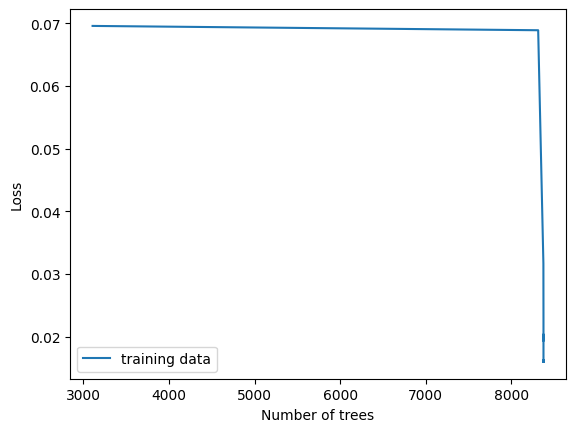

In [27]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.plot([log.evaluation.num_examples for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

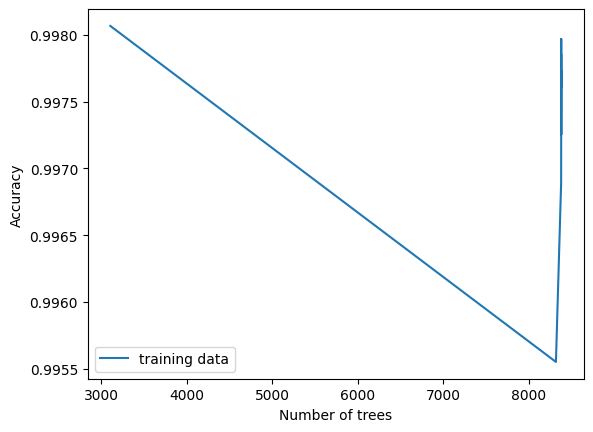

In [28]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.plot([log.evaluation.num_examples for log in logs], [log.evaluation.accuracy for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
#rf_model.predict(x_test)

In [30]:
# metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)
# y_true = np.array([[1, 1, 1],
#                    [1, 0, 0],
#                    [1, 1, 0]], np.int32)
# y_pred = np.array([[0.2, 0.6, 0.7],
#                    [0.2, 0.6, 0.6],
#                    [0.6, 0.8, 0.0]], np.float32)
# metric.update_state(y_true, y_pred)
# result = metric.result()
# result.numpy()


In [31]:
# tuner = tfdf.tuner.RandomSearch(num_trials=20)

# # Hyper-parameters to optimize.
# tuner.discret("max_depth", [4, 5, 6, 7])

# rf_model = tfdf.keras.RandomForestModel(categorical_algorithm = 'CART', tuner=tuner, num_trees=100)

# rf_model.fit(input_image_street,
#     y_train,
#     #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
#     epochs=1,
#     verbose=1)


**Logistic Regression**

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [33]:
# fit the model on the whole dataset
model.fit(X_scaled, y_train)

/home/ubuntu/capstone/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')